In [1]:
import tensorflow as tf
import numpy as np
import os
import random
from shutil import copyfile
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [10]:
session.close()

In [8]:
root_path='D:\Bangkit 2022\SKUT\Dataset_2'
#os.makedirs(os.path.join(root_path,'train'))
#os.makedirs(os.path.join(root_path,'test'))

dir_path=['Acne','Cancer','Eksim','Rosacea','Normal']
train_dir='D:\Bangkit2022\SKUT\Dataset_2/train/'
test_dir='D:\Bangkit2022\SKUT\Dataset_2/test/'

In [4]:
#make folder inside the train and test
for dir in dir_path:
   os.makedirs(os.path.join(test_dir,dir))
   os.makedirs(os.path.join(train_dir,dir))

In [5]:
def splitData(source,train_dir,test_dir,split_size):
    files=[]
    for filename in os.listdir(source):
      file=source+'/'+filename
      if os.path.getsize(file)>0:
        files.append(filename)
      else:
        print(filename+" is zero length")
    training_length=int(len(files)*split_size)
    testing_length=int(len(files)-training_length)
    shuffled_set=random.sample(files, len(files))
    training_set=shuffled_set[:training_length]
    testing_set=shuffled_set[training_length:]

    for filename in training_set:
      this_file=source+'/'+filename
      destination=train_dir+filename
      copyfile(this_file,destination)
    for filename in testing_set:
      this_file=source+'/'+filename
      destination=test_dir+filename
      copyfile(this_file,destination)
    pass

In [6]:
def dropImage(dir):
  for item in os.listdir(dir):
    path=os.path.join(dir,item)
    for file in os.listdir(path):
      sub_path=os.path.join(path,file)
      with Image.open(sub_path) as image:
            x, y = image.size
      if x<180 or y<180:
        print("Delete :"+sub_path)
        os.remove(sub_path)
dropImage(root_path+"/Dataset")

In [7]:
#Split dataset and copy into different folder
for dir in dir_path:
  splitData(root_path+'/Dataset - Copy/'+dir,train_dir+'/'+dir+'/',test_dir+'/'+dir+'/',.5)

In [4]:
#Create ImageDataGenerator
def training_testing_generator(training_dir,testing_dir):
  train_datagen=ImageDataGenerator(
      rotation_range=10,
       zoom_range=0.4,
       horizontal_flip=True,
       rescale=1/255,
       brightness_range=[0.4,1.5],
       width_shift_range=0.1,
       height_shift_range=0.1,
       fill_mode='nearest'
  )
  valid_datagen=ImageDataGenerator(rescale=1.0/255.0)
  train_generator=train_datagen.flow_from_directory(training_dir,batch_size=32,class_mode='categorical',target_size=(180,180))
  valid_generator=valid_datagen.flow_from_directory(testing_dir,batch_size=16,class_mode='categorical',target_size=(180,180))
  return train_generator,valid_generator

In [9]:
#Make the generator
train_generator, validation_generator = training_testing_generator(train_dir, test_dir)

Found 625 images belonging to 5 classes.
Found 625 images belonging to 5 classes.


In [10]:
def make_model():
    from tensorflow.keras.applications.inception_v3 import InceptionV3
    model=tf.keras.models.Sequential([
        tf.keras.applications.InceptionV3(include_top=False,input_shape=(180,180,3),),
        #tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(180,180,3)),
        #tf.keras.layers.MaxPool2D(2,2),
        #tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        #tf.keras.layers.MaxPool2D(2,2),
        #tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
        #tf.keras.layers.MaxPool2D(2,2),
        #tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
        #tf.keras.layers.MaxPool2D(2,2),
        #tf.keras.layers.Conv2D(512,(3,3),activation='relu'),
        #tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(64,activation='relu'),
        tf.keras.layers.Dense(5,activation='softmax')
    ])
    model.summary()
    return model

In [11]:
#Make model
model=make_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(train_generator,epochs=100,verbose=1,validation_data=validation_generator)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 batch_normalization_94 (Bat  (None, 32768)            131072    
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                        

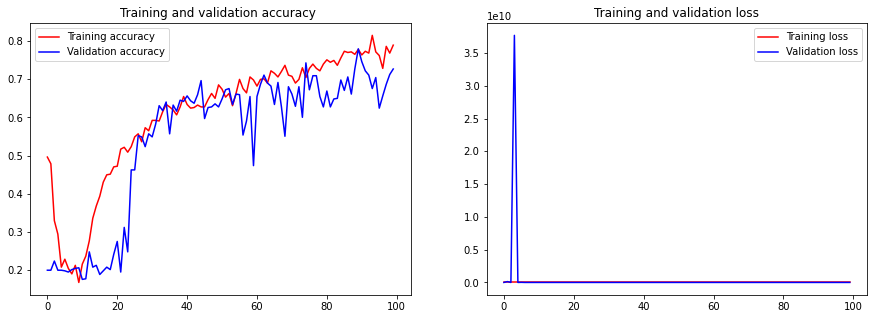

In [12]:
# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs = range(len(acc))

fig = plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy ')
plt.legend(loc=0)

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [24]:
#Predict model
import cv2
np_image = cv2.imread('D:\Bangkit2022/testing2.jfif')
np_image = np.array(np_image).astype('float32')/255
np_image = tf.image.resize(np_image, (180, 180))
np_image = np.expand_dims(np_image, axis=0)
predicted=model.predict(np_image)
print(predicted)
label = predicted.argmax(axis=-1)
print(label)

[[0.02888025 0.04455371 0.674353   0.0022355  0.24997759]]
[2]


In [25]:
np_image

array([[[[7.0343137e-01, 4.7598040e-01, 1.5196078e-02],
         [6.6764706e-01, 4.4411767e-01, 7.3529412e-03],
         [6.3725495e-01, 4.2156863e-01, 0.0000000e+00],
         ...,
         [7.0343137e-01, 4.8529410e-01, 2.1078432e-02],
         [7.0490199e-01, 4.8284313e-01, 3.2843139e-02],
         [6.8039215e-01, 4.5686275e-01, 0.0000000e+00]],

        [[6.7990196e-01, 4.4558823e-01, 1.0294118e-02],
         [6.6960788e-01, 4.3529412e-01, 1.6176471e-02],
         [6.6617650e-01, 4.3872550e-01, 0.0000000e+00],
         ...,
         [6.9754905e-01, 4.7352940e-01, 2.0098040e-02],
         [6.7843139e-01, 4.5833334e-01, 4.4117649e-03],
         [6.5441179e-01, 4.2254901e-01, 3.4313726e-03]],

        [[6.4656866e-01, 4.0735295e-01, 0.0000000e+00],
         [6.4754903e-01, 3.9656863e-01, 4.9019611e-04],
         [6.2254906e-01, 3.8676471e-01, 0.0000000e+00],
         ...,
         [6.8186277e-01, 4.5343137e-01, 3.4313726e-03],
         [6.5245098e-01, 4.4019610e-01, 3.4313726e-03],
  

In [23]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,'model_json')

In [21]:
from tensorflow import keras
model.save('Model_Testing/skut_model')

INFO:tensorflow:Assets written to: Model_Testing/skut_model\assets
